In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import json
import requests
import geopandas as gpd
import rasterio as rio

In [2]:
# Leer las comunas de la Región Metropolitana desde un archivo shapefile y dejar en crs epsg:4326
comunas = gpd.read_file('data\Comunas\comunas.shp').to_crs(epsg=4326)


In [3]:
# Guardar la comuna Maipu en un archivo shapefile solo con su geometría
maipu = comunas[comunas['Comuna'] == 'Maipú'].reset_index(drop=True)
maipu = maipu['geometry']
# Pasar a geodataframe maipu
maipu = gpd.GeoDataFrame(geometry=maipu)
maipu.head()

geometry
0  POLYGON ((-70.76505 -33.45926, -70.76505 -33.4...

In [4]:
# Leer ISMT de data\ISMT\ISMT_ZC_all_v3_average.shp
ismt = gpd.read_file('data\ISMT\ISMT_ZC_all_v3_average.shp').to_crs(epsg=4326)
# Filtrar por la comuna de Maipu
ismt_maipu = ismt[ismt['nom_cmn'] == 'MAIPÚ'].reset_index(drop=True)
# Me quedo solo con 'prom_ismt', 'AVE_GSE', geocode
ismt_maipu = ismt_maipu[['prom_ismt', 'AVE_GSE', 'geocode']]
ismt_maipu.head(1)


prom_ismt AVE_GSE      geocode
0   0.835958      C3  13119201006

In [5]:
# leer data\ZONA_C17\ZONA_C17.shp
zona_c17 = gpd.read_file('data\ZONA_C17\ZONA_C17.shp').to_crs(epsg=4326)
zonas_maipu = zona_c17.loc[zona_c17['NOM_COMUNA']=='MAIPÚ'].reset_index(drop=True) 
zonas_maipu.head(1)


REGION                        NOM_REGION PROVINCIA NOM_PROVIN COMUNA   
0     13  REGIÓN METROPOLITANA DE SANTIAGO       131   SANTIAGO  13119  \

  NOM_COMUNA URBANO  DISTRITO  LOC_ZON    GEOCODIGO  SHAPE_Leng  SHAPE_Area   
0      MAIPÚ  MAIPÚ        20        6  13119201006    0.021346    0.000025  \

                                            geometry  
0  POLYGON ((-70.76309 -33.46351, -70.76309 -33.4...

In [6]:
# Hacer join entre ismt_maipu y zonas_maipu con geocode y GEOCODIGO
ismt_maipu_zonas = ismt_maipu.merge(zonas_maipu, left_on='geocode', right_on='GEOCODIGO', how='inner')
# Me quedo solo con comuna, LOC_ZON, prom_ismt, AVE_GSE, geoemtry
ismt_maipu_zonas = ismt_maipu_zonas[['NOM_COMUNA', 'LOC_ZON', 'prom_ismt', 'AVE_GSE', 'geometry']]
# Pasar de dataframe a geodataframe ismt_maipu_zonas con crs epsg:4674
ismt_maipu_zonas = gpd.GeoDataFrame(ismt_maipu_zonas, crs=4326)
ismt_maipu_zonas.head(1)


NOM_COMUNA  LOC_ZON  prom_ismt AVE_GSE   
0      MAIPÚ        6   0.835958      C3  \

                                            geometry  
0  POLYGON ((-70.76309 -33.46351, -70.76309 -33.4...

In [7]:
# Leer data\C2017-2012_RM_pob_socioec\C2017-2012_RM_pob_socioec.shp
pob_socioec = gpd.read_file('data\C2017-2012_RM_pob_socioec\C2017-2012_RM_pob_socioec.shp').to_crs(epsg=4326)
# Intersectar maipu con pob_socioec
maipu_pob_socioec = gpd.overlay(pob_socioec, maipu, how='intersection')
maipu_pob_socioec.head(1)

MANZENT_I  puntaje_es       EDUC  puntaje_au     Hacin  Hacinpunt   
0  13102021002026  362.666667  10.447619          33  1.285354        120  \

     NSE GSE_final quintil      ID_MANZENT  ... EDAD_15A64 EDAD_6A14 PERSONAS   
0  516.0        C3      Q3  13102021002026  ...         79        13      116  \

  TOTAL_VIV index_righ    NOMBRE TIPO_AREA     SHAPE_Leng    SHAPE_Area   
0        31        385  Santiago    Ciudad  427491.444262  5.821041e+08  \

                                            geometry  
0  POLYGON ((-70.72976 -33.50992, -70.72977 -33.5...  

[1 rows x 26 columns]

In [8]:
# Dentro de una gemoetria de ismt_maipu_zonas hay varias geometrias de maipu_pob_socioec, por lo que todas estas manzanas se intersectan con la zona y estas manzanas heredan el prom_ismt de la zona a la que intersectan
# Hacer un spatial join entre ismt_maipu_zonas y maipu_pob_socioec con op='intersects'
ismt_maipu_zonas_pob_socioec = gpd.sjoin(maipu_pob_socioec , ismt_maipu_zonas, op='intersects')
# Dropear duplicados segun ID_MANZENT
ismt_maipu_zonas_pob_socioec = ismt_maipu_zonas_pob_socioec.drop_duplicates(subset='ID_MANZENT', keep='first')
ismt_maipu_zonas_pob_socioec.head(1)

c:\Users\juanm\geopandas_env\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MANZENT_I  puntaje_es      EDUC  puntaje_au     Hacin  Hacinpunt   
9  13119201006001  418.861076  11.64831           0  1.182342        120  \

          NSE GSE_final quintil      ID_MANZENT  ...    NOMBRE TIPO_AREA   
9  538.861076        C3      Q2  13119201006001  ...  Santiago    Ciudad  \

      SHAPE_Leng    SHAPE_Area   
9  427491.444262  5.821041e+08  \

                                            geometry index_right NOM_COMUNA   
9  POLYGON ((-70.76015 -33.46445, -70.76006 -33.4...           0      MAIPÚ  \

  LOC_ZON  prom_ismt  AVE_GSE  
9       6   0.835958       C3  

[1 rows x 31 columns]

<Axes: >

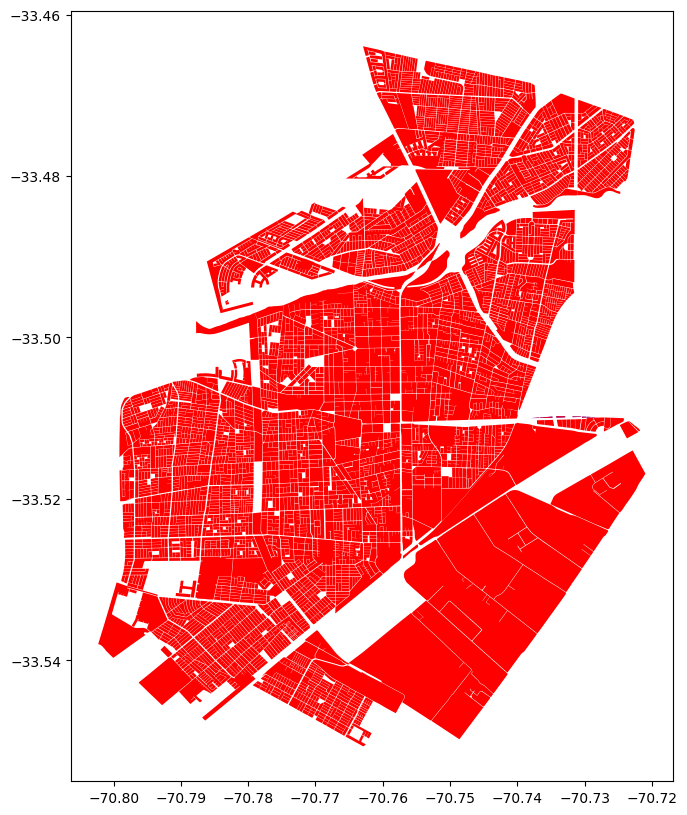

In [9]:
# obtener una lista de todos los ID_MANZENT de ismt_maipu_zonas_pob_socioec
id_manzent = ismt_maipu_zonas_pob_socioec['ID_MANZENT'].tolist()
# obtener una lista de todos los ID_MANZENT de maipu_pob_socioec
id_manzent2 = maipu_pob_socioec['ID_MANZENT'].tolist()
# Hacer la diferencia entre las dos listas
id_manzent3 = list(set(id_manzent2) - set(id_manzent))
# Filtrar maipu_pob_socioec por id_manzent3
maipu_pob_socioec_1 = maipu_pob_socioec[maipu_pob_socioec['ID_MANZENT'].isin(id_manzent3)].reset_index(drop=True)
# Graficar maipu_pob_socioec_1 y maipu_pob_socioec en una mismo plot juntos para ver en donde no se intersectan, con diferentes colores para cada uno
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
maipu_pob_socioec_1.plot(ax=ax, color='blue')
maipu_pob_socioec.plot(ax=ax, color='red')

In [10]:
for f in ['EDAD_65YMA','INMIGRANTE','PUEBLO','MUJERES','HOMBRES','EDAD_0A5','EDAD_15A64','EDAD_6A14','PERSONAS','TOTAL_VIV']:
    ismt_maipu_zonas_pob_socioec[f]=ismt_maipu_zonas_pob_socioec[f].replace('*',0)
    ismt_maipu_zonas_pob_socioec[f]=ismt_maipu_zonas_pob_socioec[f].astype('float')
    
ismt_maipu_zonas_pob_socioec=ismt_maipu_zonas_pob_socioec[ismt_maipu_zonas_pob_socioec['PERSONAS']>0].reset_index(drop=True)
ismt_maipu_zonas_pob_socioec.head(1)

MANZENT_I  puntaje_es      EDUC  puntaje_au     Hacin  Hacinpunt   
0  13119201006001  418.861076  11.64831           0  1.182342        120  \

          NSE GSE_final quintil      ID_MANZENT  ...    NOMBRE  TIPO_AREA   
0  538.861076        C3      Q2  13119201006001  ...  Santiago     Ciudad  \

      SHAPE_Leng    SHAPE_Area   
0  427491.444262  5.821041e+08  \

                                            geometry  index_right  NOM_COMUNA   
0  POLYGON ((-70.76015 -33.46445, -70.76006 -33.4...            0       MAIPÚ  \

   LOC_ZON  prom_ismt  AVE_GSE  
0        6   0.835958       C3  

[1 rows x 31 columns]

In [11]:
ismt_maipu_zonas_pob_socioec['densidad']=ismt_maipu_zonas_pob_socioec['PERSONAS']/ismt_maipu_zonas_pob_socioec.geometry.area #personas por m2
ismt_maipu_zonas_pob_socioec['pct_aMayor']=ismt_maipu_zonas_pob_socioec['EDAD_65YMA']/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
ismt_maipu_zonas_pob_socioec['pct_inm']=ismt_maipu_zonas_pob_socioec['INMIGRANTE']/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
ismt_maipu_zonas_pob_socioec['pct_orig']=ismt_maipu_zonas_pob_socioec['PUEBLO']/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
ismt_maipu_zonas_pob_socioec['pct_nna']=(ismt_maipu_zonas_pob_socioec['EDAD_0A5']+ismt_maipu_zonas_pob_socioec['EDAD_6A14'])/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
ismt_maipu_zonas_pob_socioec['pct_adult']=(ismt_maipu_zonas_pob_socioec['EDAD_15A64'])/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
ismt_maipu_zonas_pob_socioec['pct_mujeres']=(ismt_maipu_zonas_pob_socioec['MUJERES'])/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
ismt_maipu_zonas_pob_socioec['pct_hombres']=(ismt_maipu_zonas_pob_socioec['HOMBRES'])/ismt_maipu_zonas_pob_socioec['PERSONAS']*100
# Reordenar columnas y solo quedarme coin otdas aquellas que me interesan para el analisis
ismt_maipu_zonas_pob_socioec = ismt_maipu_zonas_pob_socioec[['NOM_COMUNA', 'ID_MANZENT', 'prom_ismt', 'NSE', 'GSE_final', 'TOTAL_VIV', 'densidad', 'pct_aMayor', 'pct_inm', 'pct_orig', 'pct_nna', 'pct_adult', 'pct_mujeres', 'pct_hombres', 'geometry']]
ismt_maipu_zonas_pob_socioec.head(1)

C:\Users\juanm\AppData\Local\Temp\ipykernel_4680\4011061008.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ismt_maipu_zonas_pob_socioec['densidad']=ismt_maipu_zonas_pob_socioec['PERSONAS']/ismt_maipu_zonas_pob_socioec.geometry.area #personas por m2


NOM_COMUNA      ID_MANZENT  prom_ismt         NSE GSE_final  TOTAL_VIV   
0      MAIPÚ  13119201006001   0.835958  538.861076        C3      441.0  \

       densidad  pct_aMayor   pct_inm  pct_orig    pct_nna  pct_adult   
0  2.108087e+08    5.874587  2.574257  6.336634  19.933993  74.191419  \

   pct_mujeres  pct_hombres                                           geometry  
0    51.287129    48.712871  POLYGON ((-70.76015 -33.46445, -70.76006 -33.4...

In [12]:
# Normalizar NSE, TOTAL_VIV, pct_aMayor, pct_inm, pct_orig, pct_nna, pct_adult, pct_mujeres, pct_hombres, utilizando la media y la desviacion estandar
ismt_maipu_zonas_pob_socioec['NSE'] = (ismt_maipu_zonas_pob_socioec['NSE'] - ismt_maipu_zonas_pob_socioec['NSE'].mean()) / ismt_maipu_zonas_pob_socioec['NSE'].std()
ismt_maipu_zonas_pob_socioec['TOTAL_VIV'] = (ismt_maipu_zonas_pob_socioec['TOTAL_VIV'] - ismt_maipu_zonas_pob_socioec['TOTAL_VIV'].mean()) / ismt_maipu_zonas_pob_socioec['TOTAL_VIV'].std()
ismt_maipu_zonas_pob_socioec['pct_aMayor'] = (ismt_maipu_zonas_pob_socioec['pct_aMayor'] - ismt_maipu_zonas_pob_socioec['pct_aMayor'].mean()) / ismt_maipu_zonas_pob_socioec['pct_aMayor'].std()
ismt_maipu_zonas_pob_socioec['pct_inm'] = (ismt_maipu_zonas_pob_socioec['pct_inm'] - ismt_maipu_zonas_pob_socioec['pct_inm'].mean()) / ismt_maipu_zonas_pob_socioec['pct_inm'].std()
ismt_maipu_zonas_pob_socioec['pct_orig'] = (ismt_maipu_zonas_pob_socioec['pct_orig'] - ismt_maipu_zonas_pob_socioec['pct_orig'].mean()) / ismt_maipu_zonas_pob_socioec['pct_orig'].std()
ismt_maipu_zonas_pob_socioec['pct_nna'] = (ismt_maipu_zonas_pob_socioec['pct_nna'] - ismt_maipu_zonas_pob_socioec['pct_nna'].mean()) / ismt_maipu_zonas_pob_socioec['pct_nna'].std()
ismt_maipu_zonas_pob_socioec['pct_adult'] = (ismt_maipu_zonas_pob_socioec['pct_adult'] - ismt_maipu_zonas_pob_socioec['pct_adult'].mean()) / ismt_maipu_zonas_pob_socioec['pct_adult'].std()
ismt_maipu_zonas_pob_socioec['pct_mujeres'] = (ismt_maipu_zonas_pob_socioec['pct_mujeres'] - ismt_maipu_zonas_pob_socioec['pct_mujeres'].mean()) / ismt_maipu_zonas_pob_socioec['pct_mujeres'].std()
ismt_maipu_zonas_pob_socioec['pct_hombres'] = (ismt_maipu_zonas_pob_socioec['pct_hombres'] - ismt_maipu_zonas_pob_socioec['pct_hombres'].mean()) / ismt_maipu_zonas_pob_socioec['pct_hombres'].std()
ismt_maipu_zonas_pob_socioec.head(1)


NOM_COMUNA      ID_MANZENT  prom_ismt       NSE GSE_final  TOTAL_VIV   
0      MAIPÚ  13119201006001   0.835958  0.074715        C3   9.940017  \

       densidad  pct_aMayor   pct_inm  pct_orig   pct_nna  pct_adult   
0  2.108087e+08   -0.489394  0.287186 -0.375529  0.791415   0.338051  \

   pct_mujeres  pct_hombres                                           geometry  
0    -0.126608     0.157637  POLYGON ((-70.76015 -33.46445, -70.76006 -33.4...

In [13]:
import geemap
import ee

# Iniciar flujo de autentificación 
#ee.Authenticate()
 
# Inicializar la librería.
ee.Initialize()

In [14]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name, overlay=True, control=True
    ).add_to(self)
folium.Map.add_ee_layer = add_ee_layer

In [15]:
# Creemos una visualizacion en un folium map para ver la distribucion de los ISMT en la comuna de Maipu
ismt_maipu_zonas_pob_socioec_folium = ismt_maipu_zonas_pob_socioec[['NOM_COMUNA', 'ID_MANZENT', 'prom_ismt', 'NSE', 'GSE_final', 'TOTAL_VIV', 'densidad', 'pct_aMayor', 'pct_inm', 'pct_orig', 'pct_nna', 'pct_adult', 'pct_mujeres', 'pct_hombres', 'geometry']]

poly = maipu.geometry[0]
xx, yy = poly.exterior.coords.xy
xy=[[xy[0],xy[1]] for xy in zip(xx,yy)]

aoi = ee.Geometry.Polygon(xy)

collection = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(aoi).filterDate('2023-01-01', '2023-06-28').sort('CLOUDY_PIXEL_PERCENTAGE',True)

#tomemos una imagen random de la collection
lest_cloudly = collection.toList(72).get(1)

#clip the image to the aoi
clipped_image = ee.Image(lest_cloudly).clip(aoi)
centro = [-33.518247, -70.778884]
zoom = 13

mapa = folium.Map(location=centro, zoom_start=zoom,tiles="OpenStreetMap")

# Agregar la imagen al mapa

mapa.add_ee_layer(clipped_image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'RGB')

capa_choropleth = folium.Choropleth(
                  geo_data=ismt_maipu_zonas_pob_socioec_folium,
                    name='ISMT Promedio por Manzana',
                    data=ismt_maipu_zonas_pob_socioec_folium,
                    columns=['ID_MANZENT', 'prom_ismt'],
                    key_on='feature.properties.ID_MANZENT',
                    fill_color='YlOrRd',
                    fill_opacity=0.7,
                    line_opacity=0.2,
                    legend_name='ISM T'
                ).add_to(mapa)

# agreguemos una capa de zonas_maipu
folium.GeoJson(
    zonas_maipu,
    name='Zonas Maipu',
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5'
    }
).add_to(mapa)


# Agregar control de capas
folium.LayerControl().add_to(mapa)

# agregar titulo al mapa
title_html = '''    <h3 align="center" style="font-size:20px"><b>{}</b></h3>'''.format("ISMT Promedio por Manzana comuna de Maipu")
mapa.get_root().html.add_child(folium.Element(title_html))

# Mostrar el mapa
mapa

In [16]:
# Pasar a GeoJson ismt_maipu_zonas_pob_socioec para poder ocupar geemap
maipu_ind_json = ismt_maipu_zonas_pob_socioec.to_json()
maipu_ind_json = json.loads(maipu_ind_json)

In [17]:
# Crear una lista para almacenar los polígonos individuales
polygons = []

# Iterar sobre las características en maipu_ind_json
for feature in maipu_ind_json['features']:
    coordinates = feature['geometry']['coordinates'][0]  # Obtener las coordenadas del primer polígono
    polygon = ee.Geometry.Polygon(coordinates)
    polygons.append(polygon)

# Unir todos los polígonos en uno solo
maipu_ind_geometry = ee.Geometry.MultiPolygon(polygons).dissolve()

# Graficar el polígono de maipu_ind_geometry
Map = geemap.Map()
Map.centerObject(maipu_ind_geometry, 12)
Map.addLayer(maipu_ind_geometry, {}, 'maipu_ind_geometry')
Map

Map(center=[-33.511431519987894, -70.75981695834673], controls=(WidgetControl(options=['position', 'transparen…

In [18]:
# Abrir data\Areas_urbanas\%C3%81rea_Urbana_de_Santiago_PRMS100.shp
areas_urbanas = gpd.read_file('data\Areas_urbanas\%C3%81rea_Urbana_de_Santiago_PRMS100.shp').to_crs('EPSG:4326')
# Me quedo con las COMUNA = Comunas del Gran Santiago
areas_urbanas = areas_urbanas[areas_urbanas['COMUNA'] == 'Comunas del Gran Santiago']
# intersectar con el poligono de maipu
areas_urbanas_maipu = gpd.overlay(areas_urbanas, maipu, how='intersection')

In [19]:
zonas_urbanas_json = areas_urbanas_maipu.to_json()
zonas_urbanas_json = json.loads(zonas_urbanas_json)
zonas_urbanas_geometry = ee.Geometry.MultiPolygon(zonas_urbanas_json['features'][0]['geometry']['coordinates'])

In [20]:
# Graficar el polígono de zonas_urbanas_geometry
Map = geemap.Map()
Map.centerObject(zonas_urbanas_geometry, 12)
Map.addLayer(zonas_urbanas_geometry, {}, 'zonas_urbanas_geometry')
Map

Map(center=[-33.517396555511816, -70.76292036796465], controls=(WidgetControl(options=['position', 'transparen…

In [21]:
# Crear tuplas de todos los meses de enero desde el 2019 hasta el 2022
fechas = [('2019-01-01', '2019-12-31', '2019'), ('2020-01-01', '2020-12-31', '2020'), 
          ('2021-01-01', '2021-12-31', '2021'), ('2022-01-01', '2022-12-31', '2022')]

In [22]:
# Agregar a un diccionario las imagenes de Sentinel 2 de cada mes de enero desde el 2019 hasta el 2022
dict_image_maipu = {}
for i in fechas:
    if i[2] == '2022':
        # Para el 2022 se obtiene la cuarta imagen con menor porcentaje de nubosidad
        image = ee.ImageCollection('COPERNICUS/S2')\
            .filterDate(i[0], i[1])\
            .filterBounds(zonas_urbanas_geometry)\
            .sort('CLOUDY_PIXEL_PERCENTAGE', True)\
            .toList(4, 0)\
            .get(3)
        image = ee.Image(image).clip(zonas_urbanas_geometry)
        dict_image_maipu[i[-1]] = image
    else:
        image = ee.ImageCollection('COPERNICUS/S2')\
            .filterDate(i[0], i[1])\
            .filterBounds(zonas_urbanas_geometry)\
            .sort('CLOUDY_PIXEL_PERCENTAGE', True)\
            .first()\
            .clip(zonas_urbanas_geometry)
        dict_image_maipu[i[-1]] = image

In [23]:
# hacer Map de dict_image_maipu
Map = geemap.Map()
Map.centerObject(zonas_urbanas_geometry, 12)
Map.addLayer(dict_image_maipu['2019'], {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, '2019')
Map.addLayer(dict_image_maipu['2020'], {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, '2020')
Map.addLayer(dict_image_maipu['2021'], {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, '2021')
Map.addLayer(dict_image_maipu['2022'], {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, '2022')
Map


Map(center=[-33.517396555511816, -70.76292036796465], controls=(WidgetControl(options=['position', 'transparen…

In [24]:
# calculemos el NDBI

ndbi =  dict_image_maipu['2019'].normalizedDifference(['B11', 'B4'])

# calculemops el NDVI

ndvi = dict_image_maipu['2019'].normalizedDifference(['B8', 'B4'])

ndvi_vis_params = {'min': -1, 'max': 1, 'palette': ['blue', 'white','green']}

# creemosu un trheshold para el ndvi
ndvi_threshold = ndvi.gt(0.3)

ndvi_threshold_vis_params = {'min': 0, 'max': 1, 'palette': ['white', 'green']}

ndbi_threshold = ndbi.gt(0.135)

ndbi_threshold_vis_params = {'min': 0, 'max': 1, 'palette': ['white', 'black']}

# veamos la imagen del 2023 clipeada al zona urbana de maipu
Maipu_2023 = clipped_image.clip(zonas_urbanas_geometry)


In [25]:
# grafiquemos
Map = geemap.Map()
Map.centerObject(zonas_urbanas_geometry, 12)
Map.addLayer(dict_image_maipu['2019'], {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, '2019')
Map.addLayer(Maipu_2023, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, '2023')
Map.addLayer(ndvi, ndvi_vis_params, 'ndvi')
Map.addLayer(ndvi_threshold, ndvi_threshold_vis_params, 'ndvi_threshold')
Map.addLayer(ndbi, ndvi_vis_params, 'ndbi')
Map.addLayer(ndbi_threshold, ndbi_threshold_vis_params, 'ndbi_threshold')
Map


Map(center=[-33.517396555511816, -70.76292036796465], controls=(WidgetControl(options=['position', 'transparen…

In [26]:
# Define la URL de la consulta
url = "https://sitmaipu.cl/arcgis/rest/services/Servicios/PRC_Zonificacion/MapServer/1/query"

# Define los parámetros de la consulta
params = {
    "f": "geoJSON",
    "where": "ZONA='ZC1' OR ZONA='ZC2' OR ZONA='ZC3' OR ZONA='ZC4' OR  ZONA='ZH1' OR ZONA='ZH2' OR ZONA='ZH3' OR ZONA='ZH4' OR ZONA='ZH5' OR ZONA='ZH6' OR ZONA='ZH7' OR ZONA='ZH8' OR ZONA='ZH9' OR ZONA='ZH10' OR ZONA='ZE5'",
    "outFields": "*",
    "returnGeometry": "true"
}

# Realiza la consulta
response = requests.get(url, params=params)

# Comprueba que la consulta fue exitosa
response.raise_for_status()

# Convierte la respuesta a JSON
data = response.json()

# Extrae las características (features) de la respuesta
features = data["features"]

# Filtra las características que tienen una geometría
features_with_geometry = [f for f in features if f["geometry"] is not None]

In [27]:
# crear un GeoDataFrame con los polígonos y guardando la descripción de cada polígono
zonas_habitacionales_maipu = gpd.GeoDataFrame.from_features(features_with_geometry)


In [28]:
zonas_habitacionales_maipu.head(1)

geometry  OBJECTID ZONA NOMBRE   
0  POLYGON ((-70.72604 -33.47599, -70.72595 -33.4...      1924  ZH6         \

  CARACTERISTICAS                                      CLASIFICACION   
0                  Zonas de Uso preferente vivienda con equipamiento  \

                                         DESCRIPCION   
0  Zona Habitacional 6: MaipÃº Norte - Sector Vil...  \

                     ORDENANZA MODIFICACION OBSERVACIONES OWNER   
0  \\VSITMABD\PRC_ZONA\ZH6.pdf         None          None   SDE  \

   FECHA_CREACION EDITOR  FECHA_EDICION ORDENANZA_TXT  Shape.STLength()  
0   1503273600000     AU  1503273600000          None       3912.849483

<Axes: >

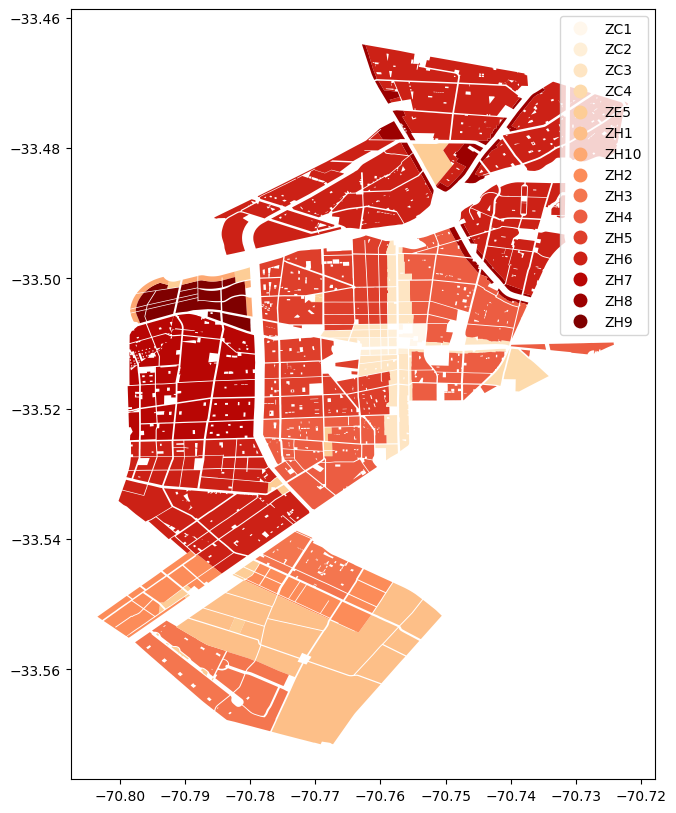

In [29]:
# Visualizar el GeoDataFrame que son las zonas habitacionales de Maipú
zonas_habitacionales_maipu.plot(column='ZONA', cmap='OrRd', legend=True, figsize=(10,10))

In [30]:
# Crear una lista para almacenar los polígonos individuales
polygons = []

# Iterar sobre features_with_geometry
for feature in features_with_geometry:
    coordinates = feature['geometry']['coordinates'][0]  # Obtener las coordenadas del primer polígono
    polygon = ee.Geometry.Polygon(coordinates)
    polygons.append(polygon)

# Unir todos los polígonos en uno solo
zonas_habitacionales_maipu_geometry = ee.Geometry.MultiPolygon(polygons).dissolve()


In [31]:
# Graficar el polígono de maipu_ind_geometry
Map = geemap.Map()
Map.centerObject(zonas_habitacionales_maipu_geometry, 12)
Map.addLayer(zonas_habitacionales_maipu_geometry, {}, 'zonas_habitacionales_maipu_geometry')
# agreguemos el poligono de color verde

Map

Map(center=[-33.51713644772224, -70.76690035678739], controls=(WidgetControl(options=['position', 'transparent…

# Veamos la diferencia asi obtengamos los elementos detectador por el NDBI que se encuentras fuera de la cobertura de las zonas habitacionales del Plan Regulador Comunal

In [32]:
zonas_no_habitacionales = gpd.overlay(areas_urbanas_maipu,zonas_habitacionales_maipu, how='difference')

# creemos una mascara en el treshold del NDBI
ndbi_threshold_mask = ndbi_threshold.updateMask(ndbi_threshold.Not())

# calculemos el area de la mascara
ndbi_threshold_area = ndbi_threshold_mask.multiply(ee.Image.pixelArea()).divide(1e6)

In [33]:
# utilicemos el ndbi para intsectarlo con las zonas habitacionales de maipu
ndbi_threshold_area_zonas_habitacionales_maipu = ndbi_threshold_area.clip(zonas_habitacionales_maipu_geometry)

In [34]:
# creemosle un buffer a zonas_habitacionales_maipu_geometry pequeño
zonas_habitacionales_maipu_geometry_buffer = zonas_habitacionales_maipu_geometry.buffer(50)

# unamos el buffer con zonas_habitacionales_maipu_geometry
zonas_habitacionales_maipu_geometry_buffer_union = zonas_habitacionales_maipu_geometry_buffer.union(zonas_habitacionales_maipu_geometry)



In [35]:
# pasemos esto a un geojson
zonas_habitacionales_maipu_geometry_buffer_union_geojson = zonas_habitacionales_maipu_geometry_buffer_union.getInfo()
# guardemoslo en un archivo
with open('zonas_habitacionales_maipu_geometry_buffer_union.geojson', 'w') as f:
    json.dump(zonas_habitacionales_maipu_geometry_buffer_union_geojson, f)

# carguemos el geojson con geopandas
zonas_habitacionales_maipu_geometry_buffer_union = gpd.read_file('zonas_habitacionales_maipu_geometry_buffer_union.geojson')


In [36]:
# tomemos solo el poligono de zonas_no_habitacionales
zonas_no_habitacionales_geometry = zonas_no_habitacionales.geometry[0]

features_no = zonas_no_habitacionales['geometry'].to_json()
# veamos features_no como un diccionario
features_no = json.loads(features_no)

In [37]:
# Crear una lista para almacenar los polígonos individuales
polygons = []

# Iterar sobre features_no
for feature in features_no['features']:
    coordinates = feature['geometry']['coordinates'][0]  # Obtener las coordenadas del primer polígono
    polygon = ee.Geometry.Polygon(coordinates)
    polygons.append(polygon)

    
# Unir todos los polígonos en uno solo
zonas_no_habitacionales_maipu_geometry = ee.Geometry.MultiPolygon(polygons).dissolve()

# ahora clipiemos el ndbi_threshold_area con zonas_no_habitacionales_maipu_geometry
ndbi_threshold_area_zonas_no_habitacionales = ndbi_threshold_area.clip(zonas_no_habitacionales_maipu_geometry)

In [41]:


mapa = geemap.Map()
mapa.centerObject(zonas_habitacionales_maipu_geometry, 12)
mapa.addLayer(Maipu_2023, {'bands': ['B12', 'B11', 'B4'], 'min': 1000, 'max': 5000}, '2023')
mapa.addLayer(zonas_habitacionales_maipu_geometry, {'color': 'green'}, 'zonas_habitacionales_maipu_geometry')
mapa.addLayer(ndbi_threshold_area_zonas_habitacionales_maipu, {'min': 0, 'max': 100}, 'ndbi_threshold_area_zonas_habitacionales_maipu')
mapa.addLayer(ndbi_threshold_area_zonas_no_habitacionales, {'min': 0, 'max': 100}, 'ndbi_threshold_area_zonas_no_habitacionales')
mapa



Map(center=[-33.51713644772224, -70.76690035678739], controls=(WidgetControl(options=['position', 'transparent…

In [39]:
# de la clipped_image obtengamos las bandas 12,11,4 en Sentinel 2
clipped_image

# calculando el urban index como la normalizacion de la banda 8 y 12
urban_index = clipped_image.normalizedDifference(['B8', 'B12'])


mapa = geemap.Map()

mapa.centerObject(zonas_habitacionales_maipu_geometry, 12)
# veamos las clipped image desde colores verde oliva a lila
mapa.addLayer(clipped_image, {'bands': ['B12', 'B11', 'B4'], 'min': 1000, 'max': 5000}, 'clipped_image')
mapa.addLayer(zonas_habitacionales_maipu_geometry, {'color': 'green'}, 'zonas_habitacionales_maipu_geometry')
mapa.addLayer(urban_index, {'min': 0, 'max': 1}, 'urban_index')
mapa


Map(center=[-33.51713644772224, -70.76690035678739], controls=(WidgetControl(options=['position', 'transparent…

In [42]:
# cipleando el urban index con zonas_habitacionales_maipu_geometry
urban_index_zonas_no_habitacionales_maipu = urban_index.clip(zonas_no_habitacionales_maipu_geometry)

In [45]:
# treshold para urban index
urban_index_threshold = urban_index_zonas_no_habitacionales_maipu.gte(0.1)

# clipiemos el urban index threshold con zonas_habitacionales_maipu_geometry


In [47]:
# veamos ahora alguna relacion entre el urban index y el ndbi
mapa = geemap.Map()

mapa.centerObject(zonas_habitacionales_maipu_geometry, 12)
# veamos las clipped image desde colores verde oliva a lila
mapa.addLayer(clipped_image, {'bands': ['B12', 'B11', 'B4'], 'min': 1000, 'max': 5000}, 'clipped_image')
mapa.addLayer(urban_index_zonas_no_habitacionales_maipu, {}, 'zonas_habitacionales_maipu_geometry')
mapa.addLayer(urban_index_threshold, {'min': 0, 'max': 1}, 'urban_index')
mapa.addLayer(ndbi_threshold_area_zonas_habitacionales_maipu, {'min': 0, 'max': 100}, 'ndbi_threshold_area_zonas_habitacionales_maipu')
mapa.addLayer(ndbi_threshold_area_zonas_no_habitacionales, {'min': 0, 'max': 100}, 'ndbi_threshold_area_zonas_no_habitacionales')
mapa

Map(center=[-33.51713644772224, -70.76690035678739], controls=(WidgetControl(options=['position', 'transparent…